In [ ]:
! pip uninstall lightgbm -y

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3


In [ ]:
!pip install lightgbm --install-option=--gpu

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 1.5 MB 4.4 MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
    Running setup.py install for lightgbm ... done


In [ ]:
import lightgbm as lgb

# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd '../gdrive/MyDrive/SSAC/3조'

/gdrive/.shortcut-targets-by-id/15_BxZVEQYCdGCGiQ5nexpWPc1cgHVe4w/3조


# CTR 예측 모델링

### 라이브러리 로드

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

In [ ]:
import joblib
import os

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# from torchvision import models
# import torch
# import torch.nn as nn

# resnet18_pretrained = models.resnet18(pretrained=True)

# num_classes = 10
# num_ftrs = resnet18_pretrained.fc.in_features
# resnet18_pretrained.fc = nn.Linear(num_ftrs, num_classes)

# device = torch.device('cuda:0')
# resnet18_pretrained.to(device)

In [ ]:
ad_df = pd.read_csv('data/ad_new.csv')
ad_df['content_img_url'] = ad_df['content_id'].apply(lambda x : f'https://media.bunjang.co.kr/product/{x}_...')

# 이미지 다운로드

In [ ]:
import os
import time
from PIL import Image

for cid in ad_df['content_id']:
    # 다운받을 이미지 url
    url = ad_df['content_img_url'][ad_df['content_id']==cid].values[0]


    # time check
    start = time.time()

    # curl 요청
    # curl "이미지 주소" > "저장 될 이미지 파일 이름" 
    os.system("curl " + url + f" > img/{cid}.jpg")

    # 이미지 다운로드 시간 체크
    print(time.time() - start)


    # 저장 된 이미지 확인
    curl_img = Image.open("./img/test.jpg")

# Resize

- 224x224로 이미지 변환

In [ ]:
from torchvision.transforms import transforms
from PIL import Image

transformationForCNNInput = transforms.Compose([transforms.Resize((224,224))])
inputDir = 'img'

cnt=0

for imageName in os.listdir(inputDir):
    I = Image.open(os.path.join(inputDir, imageName))
    I = I.convert('RGB')
    
    newI = transformationForCNNInput(I)

    if "exif" in I.info:
        exif = I.info['exif']
        newI.save(os.path.join('resize', imageName), exif=exif)
    else:
        newI.save(os.path.join('resize', imageName))

    cnt+=1
    print(cnt)

In [ ]:
cnt=0
img_name = []
res_name = []
for imageName in os.listdir('img'):
    img_name.append(imageName)
for imageName in os.listdir('resize'):
    res_name.append(imageName)

# Image to vector

In [ ]:
! pip install img2vec_pytorch

In [ ]:
from img2vec_pytorch import Img2Vec
from PIL import Image

# Initialize Img2Vec with GPU
img2vec = Img2Vec(cuda=True)
img_list = []
for cid in ad_df['content_id']:
    # 각 이미지를 리스트에 저장
    img = Image.open(f"resize/{cid}.jpg")
    img_list.append(img)
# 리스트에 저장한 이미지들을 벡터로 변환
vectors = img2vec.get_vec(img_list)

# 각 이미지 벡터를 데이터프레임으로 저장

In [ ]:
img_vec_df = pd.DataFrame()
cnt = 0
for cid in ad_df['content_id']:
    img_vec_df[cid] = vectors[cnt]
    cnt+=1

In [ ]:
vec_img_df = img_vec_df.transpose()

In [ ]:
vec_img_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
157826057,3.016677,0.142420,0.975635,0.753523,0.290007,0.291973,0.072280,0.252811,1.252024,0.575027,0.804099,0.157711,1.384216,0.959251,0.007949,1.566614,0.765723,0.701872,0.006084,0.891386,1.398643,0.253588,3.196514,0.785714,0.174183,0.602540,0.122246,0.171425,0.167559,0.454227,0.537205,0.171740,0.042436,0.154608,0.017031,0.031847,1.839602,1.788918,4.219293,0.102637,...,0.012456,2.608308,3.181628,0.802972,0.198626,0.165510,0.522535,0.003843,1.075736,0.659634,0.345358,0.542354,5.167841,0.360840,0.320556,1.056952,0.589250,0.156411,0.921165,0.028576,0.019447,0.636745,0.053568,0.013512,0.364634,0.803055,0.000000,0.047697,0.847973,0.813358,0.569595,0.337352,0.022886,0.370798,0.006441,0.320828,1.114899,0.538877,0.370549,0.002952
162431268,1.347855,0.761590,0.772083,1.823430,0.002024,0.292045,1.690807,0.851082,0.736181,0.501177,0.918906,4.070243,0.294698,0.984513,0.066298,0.211820,0.001521,0.048781,0.019491,0.016306,0.162455,0.863407,0.505076,0.224996,0.436171,0.232702,0.020941,0.986441,0.355421,0.835723,0.158188,0.430949,0.439092,1.389386,0.077916,0.010791,0.860199,0.423983,2.018535,0.706319,...,0.053095,1.701463,0.460294,0.006088,2.515916,1.729361,0.160395,0.225560,0.448763,0.416136,4.270231,0.287998,2.366089,0.100645,0.375701,0.074689,0.124141,0.079070,0.553341,0.335204,0.393771,0.643015,0.368221,0.000000,0.317295,1.389400,0.043439,0.986135,0.000380,0.338956,0.054954,1.758720,0.194506,0.050830,0.318679,0.000000,0.322381,2.135538,0.210523,0.039739
162806215,1.286740,1.692714,0.091184,2.475191,0.838820,1.262933,0.805538,1.469763,0.517492,0.073718,0.770972,0.734907,1.863907,0.803795,0.757808,0.496490,0.146726,1.517259,0.273661,0.309832,0.475656,0.055040,2.279884,1.397733,0.008655,0.924537,0.166197,0.070221,1.663775,1.040469,2.006026,2.596237,1.636780,0.165307,4.285699,1.520347,3.991241,0.965529,0.877315,0.785467,...,0.508357,0.626549,0.907911,0.000000,3.222369,0.254812,1.245659,0.277503,0.976650,0.314667,1.004464,1.186990,2.683960,1.723575,0.786954,1.567109,0.592821,0.547520,1.086959,0.002158,0.825965,0.615037,0.134329,0.010049,1.602259,0.134610,1.544158,1.614505,1.187179,0.219125,0.386516,0.188374,0.255027,0.375334,1.986270,0.217086,2.861152,1.563784,0.825358,0.125861
152625380,1.829444,0.871744,1.287986,1.365261,0.102222,0.081594,2.151578,0.849541,1.219760,0.737281,0.588966,0.735449,1.506076,0.683907,0.141763,0.211113,0.141542,0.866391,0.330103,0.937898,0.135614,0.099902,1.008836,1.558506,0.046499,0.681941,0.634317,0.065731,0.313945,0.000000,2.843067,1.261445,0.474838,0.445549,2.089250,0.487785,0.567282,1.519548,3.064315,0.376815,...,0.256633,2.550798,2.365328,0.238703,1.353672,1.227278,1.319622,1.407260,0.319481,0.052590,1.640895,0.534155,4.419817,1.046191,1.423363,1.530938,1.147858,0.349441,0.268161,0.000000,0.638944,0.256105,0.000000,0.190925,0.424208,3.593912,0.176191,0.429685,1.420244,0.563934,0.054761,0.219057,0.000000,1.546354,0.048071,0.168618,1.171574,0.353700,0.216300,0.119242
161572473,0.872876,2.322682,1.658034,0.581676,0.029889,0.215293,0.065712,0.196489,1.017796,0.078910,1.180273,1.186020,0.071653,1.742093,0.289430,0.254168,0.528319,1.325248,0.146095,0.037198,1.907376,2.342816,0.959316,0.809285,0.373064,0.430585,1.429832,2.868030,0.091221,0.331337,0.109508,0.001973,0.839128,0.524760,0.589604,0.000000,0.031336,2.061573,0.102106,0.583375,...,1.673798,0.569608,1.129281,1.959718,0.368740,0.164473,0.795974,0.119030,0.362244,1.726836,0.000000,1.437533,0.164922,0.172378,1.250064,0.314191,0.351237,0.073971,0.230209,0.773668,0.386771,1.203780,0.115228,0.027073,1.180099,0.005194,0.218748,0.014599,0.968134,0.037443,0.018059,1.386455,0.093074,0.302681,0.137158,1.061186,0.0334

In [ ]:
vec_img_df['content_id'] = ad_df['content_id']

In [ ]:
# vec_img_df.to_csv('김동영/vec_img.csv', index=False)

In [ ]:
vec_img_df = pd.read_csv('김동영/vec_img.csv')

In [ ]:
ad_image_df = ad_df[['content_id', 'name']].copy()
ad_image_df

,content_id,name
0,157826057,인텔 4세대 i5-4670 사무용 컴퓨터 팝니다.
1,162431268,갤럭시노트10+ 512GB 글로우 (무잔상) ! 0821
2,162806215,#한정판매#갤럭시S21 256GB 화이트 SS급 중고폰공기계[75333]
3,152625380,#당일발송#갤럭시S9플러스 64G 대량판매 등급별초특가!
4,161572473,포터2카고 중고화물차 팝니다.
...,...,...
1422,130344977,*당일발송*아이폰6s 최저가 판매
1423,156423859,노트10플러스 [블랙] 45301 (S급)
1424,163149174,노트20 256기가 블랙 A급 48516
1425,160955756,노트20 256기가 브론즈 A급 48011


## 코사인 유사도 함수 정의

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

# HTML로 보여주기

In [ ]:
from IPython.display import HTML, display

# id를 입력으로 받음(여기서는 ad_image_df의 인덱스)
def img_classification(id):
    sims0 = []
    # 기준 이미지와 다른 이미지들 사이의 코사인 유사도 계산
    for cid in ad_image_df['content_id']:
        vec1 = vec_img_df.iloc[id]
        vec2 = vec_img_df.loc[cid]
        sim = round(cos_sim(vec1, vec2),4)
        sims0.append(sim)
    ad_image_df['sim_0'] = sims0
    # 계산한 코사인 유사도 순으로 정렬
    sort_0 = ad_image_df.sort_values('sim_0', ascending=False)

    # 기준 이미지의 이름, 이미지 등 출력
    html = ""
    html += f'<li> 기준명 : {ad_image_df.iloc[id]["name"]}</li>'
    img_src = f'https://media.bunjang.co.kr/product/{ad_image_df.iloc[id].content_id}_...'
    html += f'<img src="{img_src}" style="width:150px;">'

    # 가장 유사한 이미지 20개 출력
    html += '<br>'
    html += f'<li> 비슷한거 20개 </li>'

    for idx in range(1, 21):
        img_src = f'https://media.bunjang.co.kr/product/{sort_0.iloc[idx].content_id}_...'
        html += f'''
            <div style="display:inline-block;min-width:150px;max-width:150px;vertical-align:top">
            <ul>
                <li>광고명: {sort_0.iloc[idx]["name"]}</li>
                <li>sim: {sort_0.iloc[idx].sim_0}</li>
                <li>content_id: {sort_0.iloc[idx].content_id} </li>
                <li>idx: {ad_image_df[ad_image_df.content_id == sort_0.iloc[idx].content_id].index.values[0]} </li>
            </ul>
            <img src="{img_src}" style="width:150px;">
            </div>
            '''

    # 가장 유사하지 않은 이미지 20개 출력
    html += '<br>'
    html += f'<li> 다른거 10개 </li>'

    for idx in range(1407, 1427):
        img_src = f'https://media.bunjang.co.kr/product/{sort_0.iloc[idx].content_id}_...'
        html += f'''
            <div style="display:inline-block;min-width:150px;max-width:150px;vertical-align:top">
            <ul>
                <li>광고명: {sort_0.iloc[idx]['name']}</li>
                <li>sim: {(sort_0.iloc[idx].sim_0)}</li>
                <li>content_id: {sort_0.iloc[idx].content_id} </li>
                <li>idx: {ad_image_df[ad_image_df.content_id == sort_0.iloc[idx].content_id].index.values[0]} </li>
            </ul>
            <img src="{img_src}" style="width:150px;">
            </div>
            '''
    display(HTML(html))

In [ ]:
img_classification(864)

## 학습 데이터 불러오기

In [ ]:
df = pd.read_csv('data/merged_data_notext.csv')

735694

# EDA

## 전처리 함수 정의

In [ ]:
categorical = [
    'viewer_gender',  
    'content_used', 
    'content_cat_2']
     
    # 'content_cat_2', 
    # 'content_cat_3']

In [ ]:
continuous = [
    'bid_price', 
    'content_price',
    'content_emergency_count',
    'content_comment_count',     
    'content_views',       
    'content_likes',    
    
    'adv_follower_count',
    'adv_grade',       
    'adv_item_count',         
    'adv_views',        
    'adv_review_count', 
    'adv_comment_count',

    'adv_pay_count',
    'adv_parcel_post_count', 
    'adv_transfer_count', 

    'adv_chat_count',
    'viewer_age',
    'viewer_following_count',
    'viewer_pay_count',
    'viewer_parcel_post_count', 
    'viewer_transfer_count',
    'viewer_chat_count']

In [ ]:
features = categorical + continuous

In [ ]:
def process_missing_values(df):
    for categorical_col in categorical:
        df[categorical_col] = df[categorical_col].astype(str)
        df[categorical_col] = df[categorical_col].fillna('0')
        df[categorical_col] = preprocessing.LabelEncoder().fit_transform(df[categorical_col])

    for continuous_col in continuous:
        df[continuous_col] = df[continuous_col].fillna(0)

    return df

## 전처리 진행

In [ ]:
df['title_len'] = df['content_name'].apply(lambda x: len(x))

In [ ]:
df = process_missing_values(df)

## 이미지 feature 추가(512개)

In [ ]:
df1 = pd.merge(df, vec_img_df)

In [ ]:
df1.to_csv('data/vec512.csv', index=False)

In [ ]:
df1[df1.content_id == 157826057][['0','1','2','3']]

,0,1,2,3
723001,3.016677,0.14242,0.975635,0.753523
723002,3.016677,0.14242,0.975635,0.753523
723003,3.016677,0.14242,0.975635,0.753523
723004,3.016677,0.14242,0.975635,0.753523


### 평균 CTR 계산

In [ ]:
grouped_label = df.groupby('label').size()
average_ctr = float(grouped_label[1]/grouped_label.sum())
average_ctr

0.03200107653453746

In [ ]:
df1.columns

Index(['content_id', 'bid_price', 'imp_id', 'imp_time', 'label', 'user_id',
       'view_time', 'adv_id', 'content_name', 'content_price',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=553)

In [ ]:
features.append('title_len')

In [ ]:
features.append('sec')

In [ ]:
vec_features = []
for i in range(512):
    vec_features.append(str(i))

## Train/Test 데이터 나누기 (8:2)

In [ ]:
train_test_df = df1[['label'] + features + vec_features]
train, test = train_test_split(train_test_df, test_size = 0.2, random_state=47)


In [ ]:
X_train = train[features + vec_features]
y_train = train['label']


In [ ]:
X_test = test[features + vec_features]
y_test = test['label']

In [ ]:
train_test_df

,label,viewer_gender,content_used,content_cat_2,bid_price,content_price,content_emergency_count,content_comment_count,content_views,content_likes,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,viewer_age,viewer_following_count,viewer_pay_count,viewer_parcel_post_count,viewer_transfer_count,viewer_chat_count,0,1,2,3,4,5,6,7,8,9,10,11,12,13,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,1,1,1,600700,50,250000,1,4,25583,817,2131,5285,247,4525,542,739,496,0,0,11,30,5,0,0,0,0,0.558485,0.494949,1.039448,0.836324,0.256143,0.522044,0.635245,0.251089,0.895208,0.711958,0.807379,2.536046,0.050859,2.202605,...,0.033936,3.049290,1.684554,0.484026,2.723213,1.283192,0.258292,0.886391,1.344672,0.676913,6.133104,0.226652,2.635666,0.298511,0.509246,0.038719,0.058445,0.396445,0.016248,0.539511,0.061262,0.749012,0.091903,0.048339,0.301149,0.414436,0.000000,0.470932,0.144566,0.037908,0.450609,0.379989,0.096850,0.451598,0.062290,0.021293,0.626392,0.310855,0.156550,0.010067
1,0,1,1,600700,50,250000,1,4,25583,817,2131,5285,247,4525,542,739,496,0,0,11,30,5,0,0,0,0,0.558485,0.494949,1.039448,0.836324,0.256143,0.522044,0.635245,0.251089,0.895208,0.711958,0.807379,2.536046,0.050859,2.202605,...,0.033936,3.049290,1.684554,0.484026,2.723213,1.283192,0.258292,0.886391,1.344672,0.676913,6.133104,0.226652,2.635666,0.298511,0.509246,0.038719,0.058445,0.396445,0.016248,0.539511,0.061262,0.749012,0.091903,0.048339,0.301149,0.414436,0.000000,0.470932,0.144566,0.037908,0.450609,0.379989,0.096850,0.451598,0.062290,0.021293,0.626392,0.310855,0.156550,0.010067
2,0,1,1,600700,50,250000,1,4,25583,817,2131,5285,247,4525,542,739,496,0,0,11,30,5,0,0,0,0,0.558485,0.494949,1.039448,0.836324,0.256143,0.522044,0.635245,0.251089,0.895208,0.711958,0.807379,2.536046,0.050859,2.202605,...,0.033936,3.049290,1.684554,0.484026,2.723213,1.283192,0.258292,0.886391,1.344672,0.676913,6.133104,0.226652,2.635666,0.298511,0.509246,0.038719,0.058445,0.396445,0.016248,0.539511,0.061262,0.749012,0.091903,0.048339,0.301149,0.414436,0.000000,0.470932,0.144566,0.037908,0.450609,0.379989,0.096850,0.451598,0.062290,0.021293,0.626392,0.310855,0.156550,0.010067
3,0,1,1,600700,50,250000,1,4,25583,817,2131,5285,247,4525,542,739,496,0,0,11,30,5,0,0,0,0,0.558485,0.494949,1.039448,0.836324,0.256143,0.522044,0.635245,0.251089,0.895208,0.711958,0.807379,2.536046,0.050859,2.202605,...,0.033936,3.049290,1.684554,0.484026,2.723213,1.283192,0.258292,0.886391,1.344672,0.676913,6.133104,0.226652,2.635666,0.298511,0.509246,0.038719,0.058445,0.396445,0.016248,0.539511,0.061262,0.749012,0.091903,0.048339,0.301149,0.414436,0.000000,0.470932,0.144566,0.037908,0.450609,0.379989,0.096850,0.451598,0.062290,0.021293,0.626392,0.310855,0.156550,0.010067
4,0,1,1,600700,50,250000,1,4,25583,817,2131,5285,247,4525,542,739,496,0,0,11,30,5,0,0,0,0,0.558485,0.494949,1.039448,0.836324,0.256143,0.522044,0.635245,0.251089,0.895208,0.711958,0.807379,2.536046,0.050859,2.202605,...,0.033936,3.049290,1.684554,0.484026,2.723213,1.283192,0.258292,0.886391,1.344672,0.676913,6.133104,0.226652,2.635666,0.298511,0.509246,0.038719,0.058445,0.396445,0.016248,0.539511,0.061262,0.749012,0.091903,0.048339,0.301149,0.414436,0.000000,0.470932,0.144566,0.037908,0.450609,0.379989,0.096850,0.451598,0.062290,0.021293,0.626392,0.310855,0.156550,0.010067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735689,0,1,0,700200,50,26000,0,12,29950,759,2120,3252,2053,32794,351,441,166,0,16,3,53,0,0,0,0,0,0.600112,1.843744,0.120049,0.171413,0.499961,0.348784,0.71

# LightGBM 학습 - 이미지 feature 포함

In [ ]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [ ]:
params = {'boosting_type': 'dart', 
        'metric': {'auc', 'binary_logloss'}, 
        'num_leaves': 127, 
        'max_depth': 15,
        'learning_rate': 0.1, 
        'feature_fraction': 0.9, 
        'bagging_fraction': 0.8, 
        'bagging_freq': 5, 
        'verbose': 0} 

model = lgb.LGBMClassifier(n_estimators=50,
    learning_rate=0.1,
    num_leaves=127,
    max_depth=15,
    zero_as_missing=True,
    n_jobs=os.cpu_count(),
    objective='binary')
print('start training')
model.fit(X_train, y_train)
print('predicting')
pred = model.predict_proba(X_test)[:,1]

print(f'auc : {roc_auc_score(y_test, pred)}, rig: {get_rig(y_train, y_test, pred)}')

start training
predicting
auc : 0.7477770870430318, rig: 0.0981724966532102


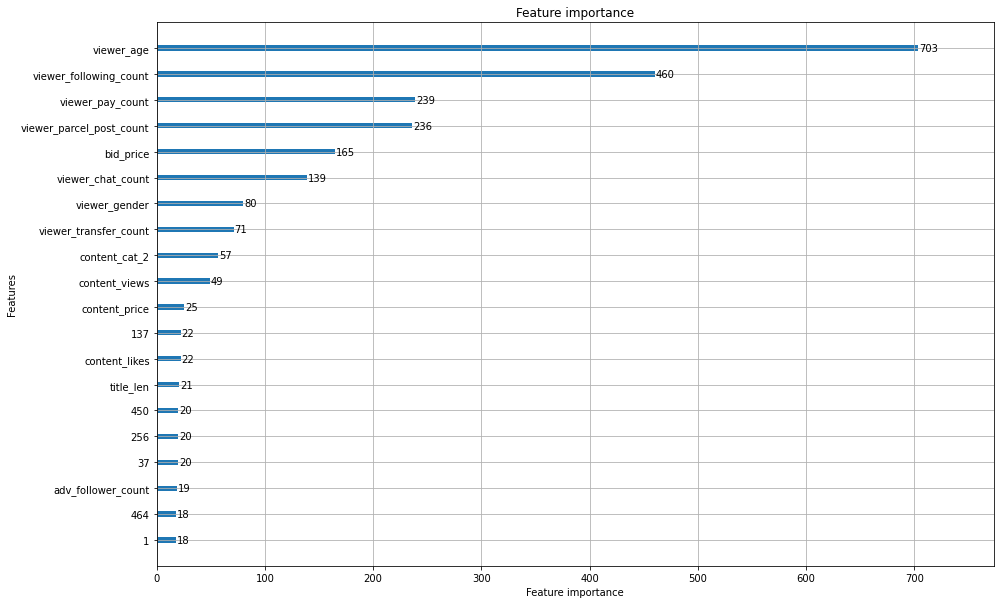

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
lgb.plot_importance(model, ax=ax, max_num_features=20)